# 月球着陆器 
训练一个智能体，安全着陆
## 目录
- 1 导入包
- 2 参数
- 3 月球着陆器环境
 - 3-1 动作空间
 - 3-2 观察空间
 - 3-3 奖励
 - 3-4 终止
- 4 加载环境
- 5 与Gym环境交互
  - 5-1 探索环境的动态
- 6 深度Q学习
 - 6-1 目标网络
 - 6-2 经验回放
- 7 带有经验回放的深度Q学习算法
- 8 更新网络权重
- 9 训练智能体
- 10 查看训练好的着陆器行动

## 1 导入包
- time：提供时间相关功能，延迟，计时等
- collections
- deque：双端队列，比list更高效地进行头尾插入/删除。用途：经验回放缓冲区实现。
- namedtuple：创建轻量级的具名元组，类似结构体。
- gym（openai gym）：构建和测试强化学习环境。
- numpy：提供高效的矩阵，向量，数学函数
- PIL.Image（Python Imaging Library）：将图像状态转化为训练数据 用于渲染月球着陆器环境
- torch：深度学习框架，张量运算，自动求导
- torch.optim：Adam等优化器
- utils：辅助函数

In [1]:
import time
from collections import deque, namedtuple

import random
import gym
import numpy as np
import PIL.Image
import torch
import torch.nn as nn
import torch.optim as optim
import utils  

In [2]:
utils.set_seed(utils.SEED)

## 2参数

In [3]:
MEMORY_SIZE=100_000  #经验回放缓冲区大小
GAMMA=0.995 #折扣因子 值越接近1未来奖励越重要 值越小现在奖励越重要
ALPHA=1e-3 #学习率
NUM_STEPS_FOR_UPDATE=4 #每四步更新一次网络 控制学习频率，平衡训练效率和稳定性

## 3月球着陆器环境
使用OpenAI的Gym库，Gym库提供了各种强化学习环境。环境-代表了一个要解决的问题

月球着陆器环境的目的是将月球着陆器安全地降落在月球表面的着陆平台上。着陆平台由两个旗杆指定，它始终位于坐标（0，0），但着陆器也允许着陆平台外着陆。着陆器从环境的顶部中心开始，其质心受到随机初始力的作用，并且具有无限燃料。如果获得200分，问题解决。
<br>
<br>
<figure>
  <img src = "月球着陆器.gif" width = 40%>
      <figcaption style = "text-align: center; font-style: italic">图片 1.着陆器环境 </figcaption>
</figure>

### 3.1 行为空间
智能体有四个离散动作可供选择：
每个动作对应一个值
- 不执行任何操作=0
- 点燃右发动机=1
- 点燃主发动机=2
- 点燃左发动机=3

### 3.2 观测空间
智能体的观测空间由8个变量的状态空间组成：

- 其坐标（x，y）。着陆平台始终位于（0，0）处。
- 其线速度$(\dot x,\dot y)$。
- 其角度$\theta$。
- 其角速度$\dot\theta$。
- 两个bool值l和r，分别表示每条腿是否与地面接触

### 3.3 奖励机制
- 成功降落在着陆平台上并静止可获得约100-140分。
- 如果着陆器远离着陆平台，扣减奖励。
- 如果着陆器坠毁，则-100分。
- 如果着陆器静止下来，则+100分。
- 每条腿与地面接触可得+10分。
- 点燃主发动机扣 -0.3分。
- 点燃侧发动机扣 -0.03分。

### 3.4 回合结束
- 月球着陆器坠毁（主体与月球表面接触）。
- 着陆器的x坐标大于1。
- 详细可看https://www.gymlibrary.dev/environments/box2d/lunar_lander/

## 4 加载环境
使用.make()方法从gym库中加载LunarLander-v2环境。Lunarlande-v2为最新版————>https://www.gymlibrary.dev/environments/box2d/lunar_lander/

In [4]:
env=gym.make("LunarLander-v2",render_mode="rgb_array")

加载了环境后，使用.reset()方法将环境重置为初始状态。着陆器位于环境的顶部中心。使用.render()渲染第一帧数。

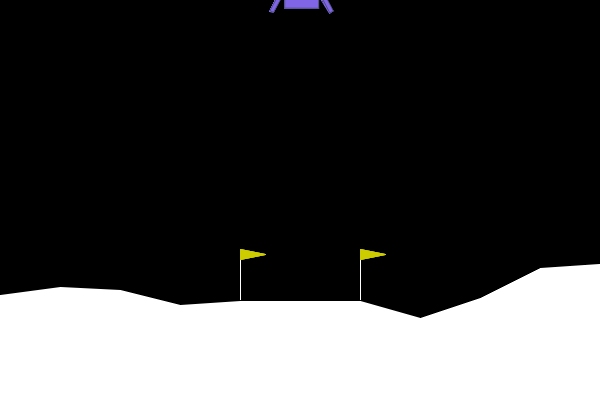

In [5]:
env.reset()
frame = env.render()  
PIL.Image.fromarray(frame)

为了后续构建神经网络，需要知道状态向量大小以及有效动作的数量。可以分别通过环境中.observation_space.shape 和 .action_space.n 方法来获取这些信息。

- 状态向量大小：env.observation_space.shape返回观测空间的维度，即状态向量的长度。
- 有效动作数量：env.action_space.n返回动作空间大小，即可选动作的总数。

这些信息分别定义神经网络的输入层（状态维度）和输出层（动作数量）。

In [6]:
state_size=env.observation_space.shape
num_action=env.action_space.n
print('state shape:',state_size)
print('num action:',num_action)

state shape: (8,)
num action: 4


## 5 与Gym环境的交互
Gym库实现了标准的“智能体——环境循环”范式：
在这个标准的“智能体——环境循环”范式中，智能体在离散时间步t=0，1，2，3...与环境交互。在每个时间步t，智能体使用策略$\pi$基于对环境状态$S_t$的观察选择动作$A_t$。智能体会获得数值奖励$R_t$，并在下一个时间步转移到新状态$S_{t+1}$。

### 5.1 探索环境动态
在OpenAI的Gym环境中，使用.step()方法来运行环境动态的单个时间步。返回五个值：
observation, reward, terminated, truncated info = env.step(action)

- observation:执行动作后的环境观察（下一状态）。
- reward：执行动作后的即时奖励。
- terminated：表示任务是否自然终止（任务完成或失败），例如游戏胜利、达到目标等。
- truncated：表示任务是否因为达到时间或步骤限制而终止，如达到最大步数。
- info：字典类型，包含额外的调试信息，具体内容依环境而异。

In [7]:
initial_state = env.reset() #初始环境

| 索引 | 含义说明            | 单位/范围             |
| -- | --------------- | ----------------- |
| 0  | 飞船的水平位置（x 坐标）   | 通常在 \[-1, 1] 之间   |
| 1  | 飞船的垂直位置（y 坐标）   | 通常在 \[-1, 1.5] 之间 |
| 2  | 飞船的水平速度（x 方向速度） | -∞ 到 ∞，一般较小       |
| 3  | 飞船的垂直速度（y 方向速度） | -∞ 到 ∞，一般较小       |
| 4  | 飞船的角度（倾斜角度）     | 弧度，-π 到 π         |
| 5  | 飞船的角速度（旋转速度）    | 弧度/秒              |
| 6  | 左脚是否接触地面（是否着陆）  | 0 或 1（布尔值）        |
| 7  | 右脚是否接触地面（是否着陆）  | 0 或 1（布尔值）        |


选择不同的值代表不同的
action=？  对应一个值
- 不执行任何操作=0
- 点燃右发动机=1
- 点燃主发动机=2
- 点燃左发动机=3


In [8]:
# 临时为 NumPy 添加 bool8 属性
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

# 选择0，1，2，3
action = 0

next_state, reward, terminated, truncated, info = env.step(action)

# 合并 terminated 和 truncated 为一个 done 标志
done = terminated or truncated

with np.printoptions(formatter={'float': '{:.3f}'.format}):
    print("Initial State:", initial_state)
    print("Action:", action)
    print("Next State:", next_state)
    print("Reward Received:", reward)
    print("Episode Terminated:", done)
    print("Info:", info)


Initial State: (array([-0.004, 1.410, -0.402, -0.033, 0.005, 0.091, 0.000, 0.000],
      dtype=float32), {})
Action: 0
Next State: [-0.008 1.409 -0.401 -0.058 0.009 0.090 0.000 0.000]
Reward Received: -0.5547516089550584
Episode Terminated: False
Info: {}


## 6 深度Q学习
当状态空间和动作空间都是离散时，可以使用贝尔曼方程迭代估计动作价值函数
$$
Q_{i+1}(s,a) = R + \gamma \max_{a'}Q_i(s',a')
$$
随着迭代次数$i\to\infty$,这个方法会收敛动作价值函数$Q^*(s,a)$。这意味着智能体只需要逐步探索状态-动作空间并持续更新$Q(s,a)$的估计。直到它收敛到最优动作函数$Q^*(s,a)$。然而，当状态空间是连续的时候，要探索整个状态-动作空间实际上变得不可能。因此逐步估计$Q(s,a)$直到收敛到$Q^*(s,a)$变的不切实际。

在深度Q学习中，使用神经网络来估计动作价值函数$Q(s,a)\approx Q^*(s,a)$来解决这个问题。称这个神经网络为Q网络，它通过在每次迭代时调整权重来最小化贝尔曼方程中的均方误差，从而进行训练。

但是，在强化学习中使用神经网络来估计动作函数已经被证明是高度不稳定的。但，可以采用几种方式来避免这种不稳定性。包括使用目标网络和经验回放。

### 6.1 目标网络：
可以通过每次迭代调整Q网络的权重w来最小化贝尔曼方程中的均方误差，目标值由下式给出：
$$
y = R + \gamma \max_{a'}Q(s',a';w)
$$
意味着在每次迭代时调整权重w来最小化以下误差：
$$
\overbrace{\underbrace{R + \gamma \max_{a'}Q(s',a'; w)}_{\rm {目标值y}} - Q(s,a;w)}^{\rm {误差}}
$$
但是存在一个问题：目标值y在每次迭代中都会发生变化。这种不断移动的目标会导致训练过程中的动荡和不稳定。

- 1问题背景：目标值会“动来动去”
在使用神经网络表示Q函数时，我们每一步都在用网络自己的输出去指导学习。这会导致：训练目标y也在不断变化，因为它依赖于当前网络的参数w。

就好比在练习射箭训练时，不断移动靶子的位置，这会导致学习模型学习的非常不稳定，甚至发散

为了解决这个问题，我们创建一个独立的神经网络来生成目标值y，我们称之为目标$\hat Q$网络，其结构与原始Q网络相同。

- 2解决方案：不再用“当前网络自己”生成目标，而是用一个“滞后版本”的网络来稳定目标
使用目标$\hat Q$网络后，误差表达式：
$$
\overbrace{\underbrace{R + \gamma \max_{a'}\hat{Q}(s',a'; w^-)}_{\rm {目标值y}} - Q(s,a;w)}^{\rm {误差}}
$$
其中$w^-$和$w$分别表示目标$\hat{Q}$网络和主$Q$网络的权重。
在实际中：
- 1 每经过C个时间步，使用目标$\hat{Q}$网络生成目标值y
- 2 使用主Q网络的权重更新目标$\hat{Q}$网络的权重
- 3 采用软更新的方式更新目标$\hat{Q}$网络的权重$w^-$
$$
w^-\leftarrow \tau w + (1 - \tau) w^-
$$
$\tau\ll 1$.（例如0.001），表示微小的将当前网络参数w混入目标网络参数$w^-$中
- 效果：目标网络的更新很慢，变化缓慢->目标值更稳定->学习更平稳。

可以想像为：原始网络是冲在一线的先锋，目标网络是稳定的后方指导，不会轻易改变主意。

软更新的优点：

- 避免了目标值的剧烈震荡（来源于目标不断的动‘动’）
- 提高了收敛性和稳定性
- 是DQN成功应用的关键 

In [9]:
class Qnetwork(nn.Module):
    def __init__(self,state_size,num_actions):
        super(Qnetwork,self).__init__()
        self.model=nn.Sequential(
            nn.Linear(state_size,64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,num_actions)
        )
    def forward(self, state):
        return self.model(state)

In [10]:
state_sizes=8
#实例化两个网络
q_network=Qnetwork(state_sizes,num_action)
target_q_network=Qnetwork(state_sizes,num_action)

#复制参数两个网络初始参数相同
target_q_network.load_state_dict(q_network.state_dict())
target_q_network.eval()  # target 网络通常不进行训练

#优化器
optimizer=optim.Adam(q_network.parameters(),lr=ALPHA)

In [11]:
from torchsummary import summary

# 假设你的输入状态是长度为 8 的向量
summary(q_network, input_size=(8,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]             576
              ReLU-2                   [-1, 64]               0
            Linear-3                   [-1, 64]           4,160
              ReLU-4                   [-1, 64]               0
            Linear-5                    [-1, 4]             260
Total params: 4,996
Trainable params: 4,996
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


### 6.2经验回放
为生么要经验回放：强化学习中，智能体的经验是时间相关性的（即一条轨迹是连续采样的），这会导致：

- 样本间高度相关性（非独立同分布，违反传统监督学习的假设）
- 学习过程容易发散，不稳定
- 随机梯度下降的效果被削弱

核心思想：将每一步经验记录下来，统一存入一个经验回放池，然后从中随机取样一批数据用于训练，打破数据之间的时间相关性

每次与环境交互得到一组数据：
$(S_t, A_t, R_t, S_{t+1})$
将其存入一个缓冲区（队列结构），之后训练时：

- 1从缓冲区随机采样一个小批量
- 2用这些样本来计算loss和梯度
- 3执行一次更新

In [12]:
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

## 7带有经验回放的深度Q学习算法

<figure>
  <img src = "deep_q_algorithm.png" width = 90% style = "border: thin silver solid; padding: 0px">
      <figcaption style = "text-align: center; font-style: italic">图片 3. 带有经验的深度Q学习算法.</figcaption>
</figure>

-  1用容量为N初始化记忆缓冲区D
-  2初始化Q网络，使用随机权重w
-  3初始化目标$\dot{Q}$网络，权重$w^-$=w
-  4for每一个回合i=1 in M do：
-  5接收初始状态$S_1$
-  6-for t=1 in T do：
-  7--观察状态$S_t$,使用ε-greedy（ε贪婪策略）选择动作$A_t$
-  8--在环境中执行动作$A_t$，接收奖励$R_t$和下一个状态$S_{t+1}$
-  9--将经验元组$(S_t, A_t, R_t, S_{t+1})$存入缓冲区D
- 10--每隔C步进行一次学习更新：
- 11---从D中随机采样一小批经验元组$(S_j, A_j, R_j, S_{j+1})$
- 12---如果第j+1步是终止状态，则设$y_j$=$R_j$否则设
$y_i = R_j + \gamma \max_{a'}Q(s_{j+1},a')$
- 13---对损失函数
$(y - Q(s_j,a_j;w))^2$做梯度下降，更新Q网络权重w
- 14---使用软更新更新目标网络$\hat{Q}$的权重
- 15--end
- 16-end

### 实现图3中的12

In [13]:
import torch.nn.functional as F

def compute_loss(experiences, gamma, q_network, target_q_network):
    """ 
    使用 PyTorch 计算 DQN 中的均方误差（MSE）损失。

    参数：
        experiences: 元组，包含 (states, actions, rewards, next_states, done_vals)
        gamma: 折扣因子（float）
        q_network: 当前 Q 网络（用于预测当前状态下的动作价值）
        target_q_network: 目标 Q 网络（用于预测目标 Q 值）

    返回：
        loss: 均方误差损失（torch.Tensor）
    """

    # 解包经验元组
    states, actions, rewards, next_states, done_vals = experiences

    # 使用目标网络计算下一状态的最大 Q 值（不需要梯度）
    with torch.no_grad():
        max_next_q_values = target_q_network(next_states).max(dim=1)[0]

    # 计算目标值 y：
    # 如果 done 为 1，说明 episode 结束，只使用 reward；
    # 如果 done 为 0，使用 Bellman 方程：reward + gamma * max_next_q
    y_targets = rewards + gamma * max_next_q_values * (1 - done_vals)

    # 使用当前网络计算每个状态对应动作的 Q 值 Q(s,a)
    q_values = q_network(states)
    actions = actions.long().unsqueeze(1)  # 扩展维度以便用于 gather
    q_values = q_values.gather(1, actions).squeeze(1)  # 按照动作索引提取 Q 值

    # 计算均方误差损失
    loss = F.mse_loss(q_values, y_targets)

    return loss

## 8更新网络权重

In [14]:
def agent_learn(experiences, gamma, q_network, target_q_network, optimizer, utils):
    """
    更新 Q 网络的参数。
    
    参数：
        experiences: tuple，包含 (states, actions, rewards, next_states, done_vals)
        gamma: 折扣因子（float）
        q_network: 当前 Q 网络（torch.nn.Module）
        target_q_network: 目标 Q 网络（torch.nn.Module）
        optimizer: 用于训练 q_network 的优化器（如 Adam）
        utils: 工具模块，包含 update_target_network 函数
    """

    # 清零梯度
    optimizer.zero_grad()
    
    # 计算损失
    loss = compute_loss(experiences, gamma, q_network, target_q_network)

    # 反向传播
    loss.backward()

    # 更新 q_network 参数
    optimizer.step()

    # 将 q_network 的权重复制到 target_q_network
    utils.update_target_network(q_network, target_q_network)


## 9训练智能体

- 第一行：使用容量为N=MEMERY_SIZE来初始化memory_buffer(内存缓冲区)，使用deque数据结构来作为内存缓冲区
- 第二行：初始化q_network,已经在6中完成
- 第三行：通过将q_network的权重赋值给target_q_network来初始化target_q_network
- 第四行：外层循环，设置M=num_episodes=2000（因为使用默认的参数可以在不超过两千次训练解决lunar lander环境问题）。
- 第五行：使用.reset()方法将环境重置为初始状态，并获取初始的state(状态S)。
- 第六行：内层循环，设置T=max_num_timesteps=1000。如果在1000步后还没有终止，训练会自动终止该回合
- 第七行：智能体观察当前的state（状态S）并使用$\epsilon$贪婪策略随机选择一个action。我们智能体初始使用$\epsilon$=1，这意味着策略是等概率随机策略，也就是一开始会随机选择动作。随着训练的进行，我们会逐渐降低$\epsilon$的值趋近于最小值（如0.01）。这个值不能是0，因为要保留一部分探索性。实现$\epsilon$贪婪策略在utils.get_action函数中实现。
- 第八行：使用.step()方法将选定的action应用于环境中，并获得对应的reward（R奖励）和next_state（下一个状态S）。
- 第九行：将experience(state, action, reward, next_state, done) 元组存入 memory_buffer 中。特别注意：存储了done变量，可以追踪回合是否终止，对设置7中实现的y_targets（目标）很重要。
- 第十行：检查是否满足执行学习更新的条件。通过utils.check_update_conditions 函数实现。检查是否经过了C=NUM_STEPS_FOR_UPDATE=4步，以及memry_buffer（内存缓冲区）中是否有足够的经验组来填满一个mini_batch（batch=64，至少需要64组）。满足条件 return true。
- 第11-14行：update变量为true，执行学习更新。从memry_buffer（内存缓冲区）中随机采样mini-batch、设置y_targets（目标）、执行梯度下降，并更新网络权重。用8中的agent_learn实现。
- 第15行：每次内层循环（6-14）结束后，更新状态S，即next_state设置为新的state，以便下一轮循环继续执行。此外，我们会检查该回合是否达到终极状态（即done=True），若达到，则跳出内层循环。
- 第16行：每次外层循环结束后，更新$\epsilon$值，检查环境是否被解决。定义：智能体在100次回合中的平均得分>=200,视为解决环境。没解决继续循环。
  <figure>
  <img src = "deep_q_algorithm.png" width = 40% style = "border: thin silver solid; padding: 0px">
      <figcaption style = "text-align: center; font-style: italic">图片 3. 带有经验的深度Q学习算法.</figcaption>
</figure>

In [15]:
start=time.time()
num_episodes=2000
max_num_timesteps=1000

total_point_history=[]

num_p_va=100
epsilon=1

memory_buffer=deque(maxlen=MEMORY_SIZE)

target_q_network.load_state_dict(q_network.state_dict())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for i in range(num_episodes):
    state,_=env.reset()
    total_points=0
    for t in range(max_num_timesteps):
        state_qn=np.expand_dims(state,axis=0) #将 state 从形状 (n,) 扩展为 (1, n)，因为神经网络模型（q_network）通常需要输入一个**批量（batch）**的形式，即二维数组。
        state_qn_tensor = torch.tensor(state_qn, dtype=torch.float32).to(device)
        q_values=q_network(state_qn_tensor)
        action=utils.get_action(q_values,epsilon)
        next_state,reward,terminated,truncated,info=env.step(action)
        done=terminated or truncated
        memory_buffer.append(experience(state,action,reward,next_state,done))

        update=utils.check_update_conditions(t,NUM_STEPS_FOR_UPDATE,memory_buffer)

        if update:
            experiences=utils.get_experiences(memory_buffer)
            agent_learn(experiences,GAMMA,q_network, target_q_network, optimizer, utils)
        state=next_state.copy()
        total_points+=reward

        if done:
            break
    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_va:])#从倒数第100一直到结束 这些值的平均值
    
    epsilon = utils.get_new_eps(epsilon)
    
    print(f"\rEpisode{i+1}|最近100次回合中平均值为：{av_latest_points:.2f}", end="")

    if (i+1) % num_p_va == 0:
        print(f"\rEpisode {i+1} | 最近100次回合中平均值为：{av_latest_points:.2f}")

    if av_latest_points >= 200.0:
        print(f"\n\n环境在{i+1} 解决!")
        torch.save(q_network.state_dict(), 'lunar_lander_model.pth')
        break
tot_time = time.time() - start

print(f"\n花费了{tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episode 100 | 最近100次回合中平均值为：-166.03
Episode 200 | 最近100次回合中平均值为：-91.76
Episode 300 | 最近100次回合中平均值为：-45.88
Episode 400 | 最近100次回合中平均值为：-9.80
Episode 500 | 最近100次回合中平均值为：106.51
Episode 600 | 最近100次回合中平均值为：179.70
Episode 700 | 最近100次回合中平均值为：199.03
Episode710|最近100次回合中平均值为：200.44

环境在710 解决!

花费了252.29 s (4.20 min)


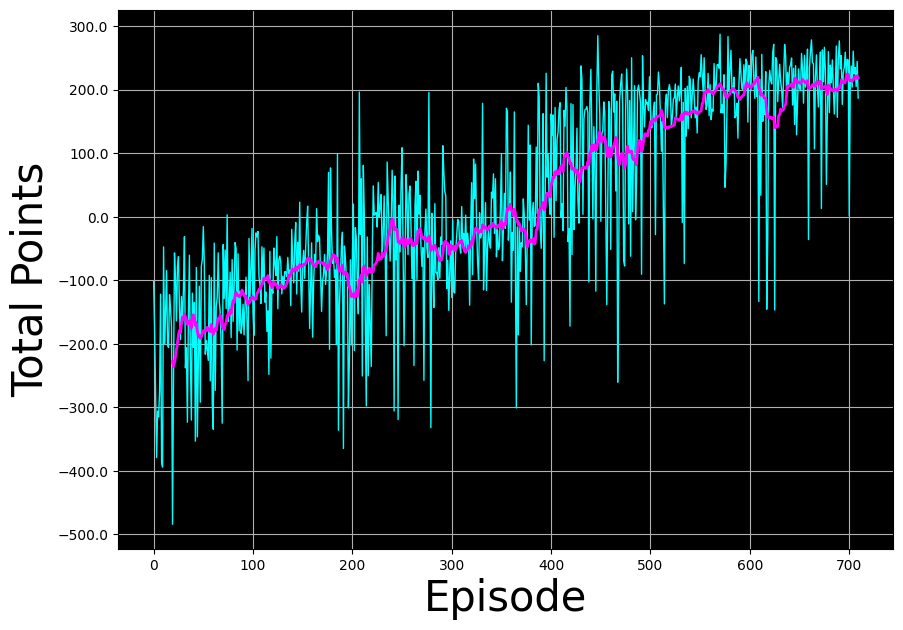

In [19]:
utils.plot_history(total_point_history)

In [20]:
# Suppress warnings from imageio
import logging
logging.getLogger().setLevel(logging.ERROR)

In [24]:
filename = "lunar_lander.mp4"

utils.create_video(filename, env, q_network)
utils.embed_mp4(filename)